In [ ]:
# Copyright 2017 Department of Electrical and Computer Engineering, Cornell University. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This is a package for locally private data transmission. 

In [30]:
%matplotlib inline
import math
import numpy as np
import random
import matplotlib.pyplot as plt
#the Hadamard randamized responce when \epsilon < 1
class Hadamard_Rand_1:
    def __init__(self, absz, pri_para): # absz: alphabet size, pri_para: privacy parameter
        self.insz = absz #input alphabet size k
        self.outsz = int(math.pow(2,math.ceil(math.log(absz+1,2)))) #output alphabet size: smallest exponent of 2 which is bigger than k
        self.outbit = int(math.ceil(math.log(absz+1,2))) #output bit length
        self.pri_para = 1/(1+math.exp(pri_para))
        self.exp = math.exp(pri_para)

    def parity_check(self,x,y): #check if the hadamard entry is one (return 0 for 1)
        z = x&y
        z_bit = bin(z)[2:].zfill(self.outbit)
        check = 0
        for i in range(0,self.outbit):
            check = check^int(z_bit[i])
        return check
                                  
    def encode_symbol(self,ori):  # encode a single symbol into a privatized version
        bitin = bin(int(ori)+1)[2:].zfill(self.outbit)
        out1 = random.randint(0,math.pow(2,self.outbit)-1)
        bitout1 = bin(out1)[2:].zfill(self.outbit)
        for i in range(0,self.outbit):
            if int(bitin[i]) == 1:
                out2 = out1 ^ (pow(2,self.outbit - i -1))
                break   
        bitout2 = bin(out2)[2:].zfill(self.outbit)
        check = 0
        for i in range(0,self.outbit):
            check = check^(int(bitout1[i])&int(bitin[i]))
        ra = random.random()
        if check == 0:
            if ra > self.pri_para:
                return out1
            else:
                return out2
        else:
            if ra > self.pri_para:
                return out2
            else:
                return out1          
     
    def encode_string(self,in_list):  # encode string into a privatized string
        out_list = [a.encode_symbol(x) for x in in_list]
        return out_list
    
    def decode_string(self, out_list): # get the privatized string and learn the original distribution
        l = len(out_list)
        num = [0]*self.insz
        count = [0]*self.outsz
        for x in out_list:
            count[x] = count[x] + 1
        
        for x in range(0,self.outsz):
            #print x
            for i in range(1, self.insz+1):
                if self.parity_check(i,x) == 0:
                    num[i-1] = num[i-1] + count[x]
        dist_S = [float(x)/float(l) for x in num]
        dist = [(2*x*(1+self.exp)-(1+self.exp))/(self.exp-1) for x in dist_S]
        return dist

In [31]:
#The Hadamard randomized response for all regimes
class Hadamard_Rand_2:
    def __init__(self, absz, pri_para): # absz: alphabet size, pri_para: privacy parameter
        self.insz = absz #input alphabet size k
        #self.outsz = int(math.pow(2,math.ceil(math.log(absz+1,2)))) #output alphabet size: smallest exponent of 2 which is bigger than k
        #self.outbit = int(math.ceil(math.log(absz+1,2))) #output bit length
        self.pri_para = 1/(1+math.exp(pri_para))
        self.exp = math.exp(pri_para)
        self.initbit = int(math.ceil(math.log(self.exp,2)))
        self.part = int(math.pow(2,self.initbit))
        self.tailbit = int(math.ceil(math.log(float(self.insz)/float(self.part)+1,2)))
        self.partsz = int(math.pow(2,self.tailbit))
        self.outbit = self.tailbit + self.initbit
        self.outsz = int(math.pow(2,self.outbit))

    def entry_check(self,x,y): #check if the reduced hadamard entry is one (return 0 for 1)
        x_bit = bin(x)[2:].zfill(self.outbit)
        y_bit = bin(y)[2:].zfill(self.outbit)
        for i in range(0,self.initbit):
            if x_bit[i] != y_bit[i]:
                return 1
        check = 0
        for i in range(self.initbit, self.outbit):
            check = check^(int(x_bit[i])&int(y_bit[i]))
        return check
                                  
    def encode_symbol(self,ori):  # encode a single symbol into a privatized version 
        ori1 = int(ori)/(self.partsz-1)*self.partsz + int(ori)%(self.partsz-1)+1
        bitin = bin(int(ori1))[2:].zfill(self.outbit)
        out1 = random.randint(0,self.outsz-1)
        ra = random.random()
        if ra < (2*self.part)/(2*self.part-1+self.exp):
            return out1
        else:
            out1 = out1%self.partsz + self.partsz*(ori1/self.partsz)
            if self.entry_check(ori1,out1) == 0:
                return out1
            else:
                for i in range(self.initbit, self.outbit):
                    if int(bitin[i]) == 1:
                        out1 = out1 ^ (pow(2,self.outbit - i -1))
                        break
                return out1
     
    def encode_string(self,in_list):  # encode string into a privatized string
        out_list = [a.encode_symbol(x) for x in in_list]
        return out_list
    
    def decode_string(self, out_list): # get the privatized string and learn the original distribution
        l = len(out_list)
        num = [0]*self.insz
        count = [0]*self.outsz
        for x in out_list:
            count[x] = count[x] + 1
            
        count_block = [0]*self.part
        for i in range(0,self.part):
            for j in range(0,self.partsz):
                count_block[i] = count_block[i] + count[i*self.partsz+j]
        
        freq_block = [float(x)/float(l) for x in count_block]
        dist_block = [((2*self.part-1+self.exp)*x-2)/(self.exp-1) for x in freq_block]
        
        for x in range(0,self.outsz):
            #print x
            for i in range(0, self.insz):
                ti = int(i)/(self.partsz-1)*self.partsz + int(i)%(self.partsz-1)+1
                if self.entry_check(ti,x) == 0:
                    num[i] = num[i] + count[x]
    
        dist_S = [float(x)/float(l) for x in num]
        dist_inter = [2*(x*(2*self.part-1+self.exp)-1)/(self.exp-1) for x in dist_S]
        dist = [dist_inter[i] - dist_block[i/(self.partsz-1)] for i in range(0,self.insz)]
        return dist

32
4
l1 distance: 0.200999594868
prob_sum: 0.955334796086


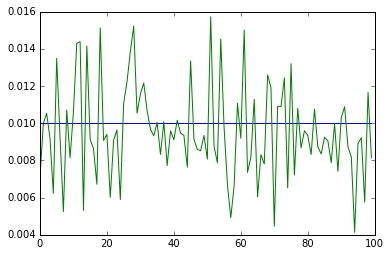

In [32]:
k = 100 #absz
elements = range(0,k) #ab
lbd = 0.8 #parameter for geometric dist
eps = 1 # privacy_para
prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
#prob = [1/float(k)] * k
in_list = np.random.choice(elements, 1000000, p=prob) #input symbols
a = Hadamard_Rand_2(k,eps) 
print a.partsz
print a.part
outp = a.encode_string(in_list)
#print outp
prob_est = a.decode_string(outp) # estimate the original underlying distribution
plt.plot(elements,prob)
plt.plot(elements,prob_est)
#plt.plot(prob_est)
print 'l1 distance: ' + str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1))
print 'prob_sum: ' + str(sum(prob_est))

l1 distance0.187218078643
prob_sum0.996465923772


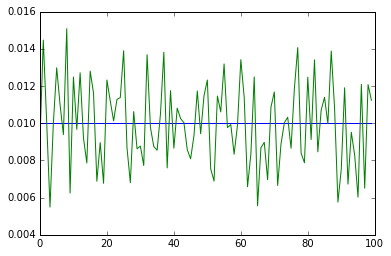

In [33]:
# test file
k = 100 #absz
elements = range(0,k) #ab
lbd = 0.8 #parameter for geometric dist
eps = 1 # privacy_para
prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
#prob = [1/float(k)] * k
in_list = np.random.choice(elements, 1000000, p=prob) #input symbols
a = Hadamard_Rand_1(k,eps) # define the private channel
outp = a.encode_string(in_list) # get the output string
prob_est = a.decode_string(outp) # estimate the original underlining distribution
plt.plot(elements,prob)
plt.plot(elements,prob_est)
print 'l1 distance' + str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1))
print 'prob_sum' + str(sum(prob_est))

In [ ]:
k = 100 #absz
elements = range(0,k) #ab
lbd = 0.8 #parameter for geometric dist
eps = 1 # privacy_para
#prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
prob = [1/float(k)] * k
#in_list = np.random.choice(elements, 100000, p=prob) #input symbols
n = 1
in_list = [n]*100000
outp = a.encode_string(in_list)
count = [0]*a.outsz
for x in outp:
    count[x] = count[x] + 1
plt.plot(count)

a = Hadamard_Rand_2(k,eps) 
x = random.randint(0,a.outsz-1)
y = random.randint(0,a.outsz-1)
x_bit = bin(int(x))[2:].zfill(a.outbit)
y_bit = bin(int(y))[2:].zfill(a.outbit)
print a.initbit
print a.tailbit
print 'x:' + x_bit
print 'y:' + y_bit
print a.entry_check(x,y)
print a.partsz
print int(n)/(a.partsz-1)*a.partsz + int(n)%(a.partsz-1)+1